# Hankel Alternative View of Koopman

Text(0.5, 0, 't')

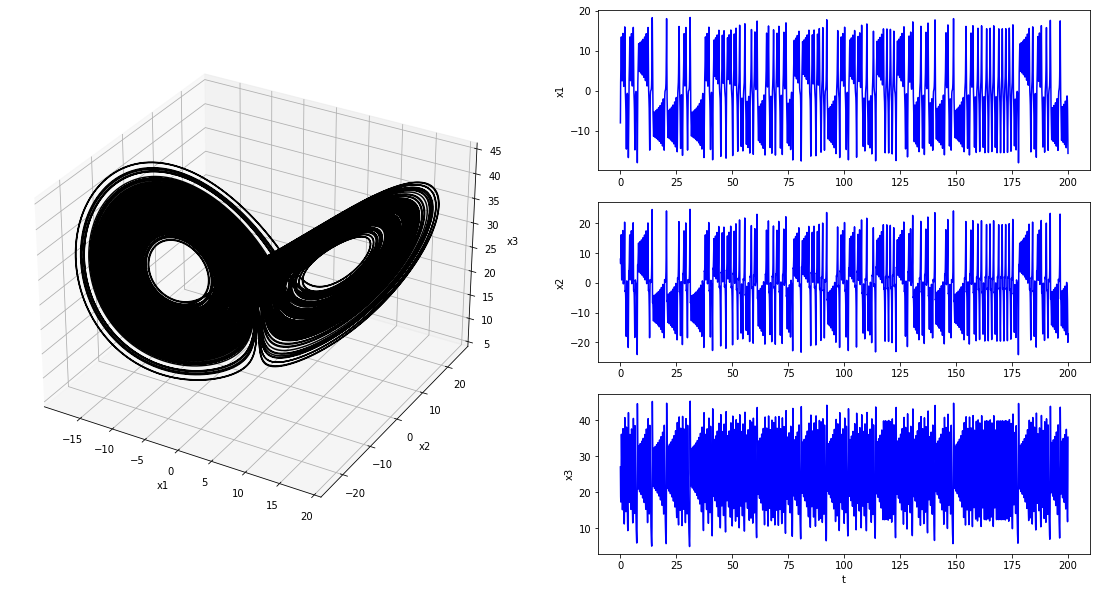

In [1]:
import numpy as np
from scipy import integrate
from math import e
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pykoopman as pk

n_states = 3
x0 = [-8, 8, 27]  # initial condition
dt = 0.001
t = np.linspace(dt, 200, 200000)

def lorenz(x, t, sigma=10, beta=8/3, rho=28):
    return [
        sigma*(x[1]-x[0]),
        x[0]*(rho-x[2])-x[1],
        x[0]*x[1]-beta*x[2]
    ]

x = integrate.odeint(lorenz, x0, t, atol=1e-12, rtol=1e-12)


fig = plt.figure(figsize=(30,10))
gs = GridSpec(3, 3, figure=fig)

ax1 = fig.add_subplot(gs[:, 0], projection='3d')
ax1.plot3D(x[:, 0], x[:, 1], x[:, 2], '-k')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('x3')
ax1.grid()

ax2a = fig.add_subplot(gs[0, 1])
ax2a.plot(t, x[:, 0], '-b', label='x')
ax2a.set_ylabel('x1')
ax2b = fig.add_subplot(gs[1, 1])
ax2b.plot(t, x[:, 1], '-b', label='y')
ax2b.set_ylabel('x2')
ax2c = fig.add_subplot(gs[2, 1])
ax2c.plot(t, x[:, 2], '-b', label='z')
ax2c.set_ylabel('x3')
ax2c.set_xlabel('t')


In [2]:
TDC = pk.observables.TimeDelay(delay=1, n_delays=99)
HAVOK = pk.regression.HAVOK(svd_rank=15)

model = pk.Koopman(observables=TDC, regressor=HAVOK)
model.fit(x[:, 0], dt=dt)


Koopman(observables=TimeDelay(n_delays=99), regressor=HAVOK(svd_rank=15))

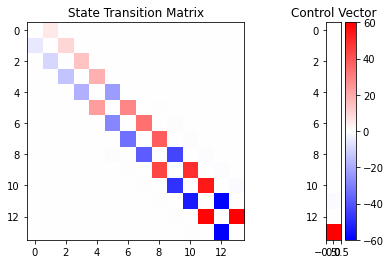

In [3]:
fig = plt.figure()
gs = GridSpec(1, 2, width_ratios=[3, 1])

ax0 = plt.subplot(gs[0])
im = ax0.imshow(model.state_transition_matrix, aspect='equal', cmap=plt.get_cmap('bwr'),
           vmin=-60, vmax=60)
ax0.set(title='State Transition Matrix')

ax1 = plt.subplot(gs[1])
im = ax1.imshow(model.control_matrix[:, np.newaxis], aspect='equal', cmap=plt.get_cmap
('bwr'), vmin=-60, vmax=60)
ax1.set(title='Control Vector')
fig.colorbar(im, ax=ax1)

array([[  0.,   5.,   0.,   0.,   0.,  -0.,  -0.,  -0.,   0.,   0.,  -0.,
          0.,   0.,  -0.],
       [ -5.,  -0.,  10.,  -0.,   0.,   0.,  -0.,  -0.,  -0.,  -0.,   0.,
         -0.,  -0.,   0.],
       [ -0., -10.,  -0.,  14.,  -0.,  -0.,   0.,  -0.,   0.,   0.,  -0.,
          0.,   0.,  -0.],
       [ -0.,  -0., -14.,  -0.,  19.,   0.,  -0.,   0.,  -0.,   0.,   0.,
          0.,   0.,  -0.],
       [ -0.,  -0.,  -0., -18.,  -0., -23.,   0.,  -0.,   0.,   0.,   0.,
          0.,  -0.,   0.],
       [ -0.,   0.,   0.,   0.,  23.,  -0.,  28.,  -0.,   0.,  -0.,  -0.,
         -0.,   0.,   0.],
       [ -0.,  -0.,   0.,   0.,   0., -28.,  -0.,  33.,  -0.,  -1.,  -0.,
         -0.,   0.,   0.],
       [ -0.,  -0.,   0.,   0.,   0.,  -0., -33.,   0.,  38.,   0.,  -1.,
         -0.,   0.,   0.],
       [ -0.,   0.,  -0.,   0.,  -0.,  -1.,   0., -38.,  -0., -44.,   0.,
         -1.,   0.,   0.],
       [ -0.,   0.,  -0.,   0.,  -0.,  -0.,   1.,  -0.,  44.,  -0.,  49.,
         -0.,  -1